# From Scratch Series

## 2. Artifical Neural  Networks

Here, we will attempt to formulate a intuitive understanding of how an artificial neural network works, along with building and explaining each component that forms part of the neural network. This article assumes that you are familiar with the basic concepts of machine learning and know a bit of elementary statistics and matrix algebra.

We'll only use the base numpy and scipy libraries for creating a neural network from scratch. We use these liibraries to abstract out the details of basic operations like matrix multiplications & array handling, along with matplotlib for plotting  images.

### First, the Neuron

We can start off by defining what a single neuron is. A neuron can be thought of as an object that holds a number - and this number signifies how active or excited the object is.  Higher the value of this number, more active the neuron is, and vice versa. The neuron object has an input port which can be used to control how excited the neuron becomes. A function that takes this input and turns it into the activation level of the neuron is called the *activation function*. This activation or excitation level then becomes the output of that neuron.

For now, let us assume that activation of a neuron is bounded within the range \[0, 1\] for any given input. So, for any numeric input to the neuron in the interval $[-\infty, \infty]$, we need to design an activation function that takes this input number and squishes it into a number between 0 and 1. We can think of the state 0 as the state of the neuron being completely inactive, and 1 as the state of neuron being fully activated. 

Let us design this activation function now. For now, the only requirement we have is that for any input, the function squishes the input into a number between 0 and 1. There is a very familiar function that maps an arbitrary input into \[0, 1\] interval - the **logit** function which is commonly used in logistic regression.


\begin{align}
f(x) = \frac{1}{1 + e^{-k(x - x_0)} }
\end{align}

For keeping things simple, we use k=1, and x<sub>0</sub> = 0 as default for now, which makes the equation

\begin{align}
f(x) = \frac{1}{1 + e^{x} } = \sigma(x)
\end{align}

We call this special case of the logit function as the **sigmoid**, and use a $\sigma$ to represent it. Let us write some code to implement this function.

In [8]:
import numpy as np
import matplotlib as mtl
import pandas as pd
from matplotlib import pyplot
from IPython.display import display, HTML, Markdown # For printing nice looking tables from pandas dataframes
from scipy import optimize # We will use this for mathematical optimisations later on

# For printing dataframe tables side by side
CSS = """
div.cell:nth-child(10) .output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))

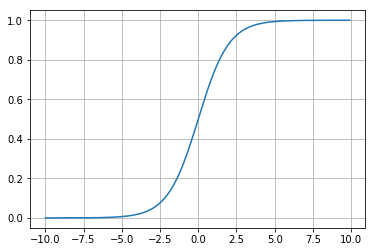

In [9]:
def sigmoid(x):
    return 1./(1. + np.exp(-1.* x) )

pyplot.plot(np.arange(-10, 10, 0.1), sigmoid(np.arange(-10, 10, 0.1)))
pyplot.grid(True)
pyplot.show()

### The neural network

A neural network, as the name suggests, is a set of interconnected neurons. In biological neural networks, individual neurons are connected to each other through connections called synapses. Each synapse has a weight associated with it; this weight determines how strongly two neurons are connected to each other. A signal passed from one neuron to the next through this synapse is amplified (or attenuated) proportional to the weight of the synaptic connection.

The artificial neural network we are constructing here can be be thought of as a bunch of artificial neurons that are linked to each other, with each link having an associated strength - just as in the biological counterpart. When the output from one neuron passes to the subsequent neuron, it gets scaled by the strength of the link that connects the two neurons. This strength is called the **weight** of the link, and the weight is also just a number, just like neuron activation levels.

As an example, consider the simplest case with 2 neurons connected to each other through a link, and let the weight of the link be $w$. For an input $x$ to neuron 1, the activation function $\sigma_1$ squishes $x$ into an number between 0 and 1, and this  is then passed to the synaptic link. The number is then scaled by the weight $w$ of the link, and becomes the input to neuron 2. Now the activation function $\sigma_2$ of neuron 2 picks this value up and squishes it to \[0, 1\], which is the output of neuron 2.

Hence the final output $y$ is given by  $ y = \sigma_2( \sigma_1(x) * w) ) $.



In [10]:
# Create a 2 neuron network, with 'x' as input and 'w' as weight of the link between the 2 neurons
def simplest_neural_network(x, w):
    return sigmoid(sigmoid(x)*w)

print("Large input: x=20 gives ", simplest_neural_network(x = 20, w = 4)) 
print("Small input: x=-20 gives ", simplest_neural_network(x = -20, w = 4)) 


Large input: x=20 gives  0.982013789892
Small input: x=-20 gives  0.500000002061



Now we're ready to start conceptualising slightly more complex neural network structures. Before we consider the neural network structure, consider the following problem- let's say we are supplied a set of $n$ numbers, and are asked to guess a function that takes these $n$ numbers as input and produces an number $y$. In mathematical terms, we are asked to guess function $f$ in the following equation-

\begin{align}
y = f(x_1, x_2, ..., x_n)
\end{align}

To make the function a bit easier to guess, let's say we are given several such input-output pairs that the function should produce. Suppose that we are given $m$ such pairs of inputs and outputs- in that case, we can rewrite the equation in matrix terms -

\begin{align}
\begin{bmatrix}
x_{11} & x_{12} & ... & x_{1n} \\
x_{21} & x_{22} & ... & x_{2n} \\
: & : & : & : \\
x_{m1} & x_{m2} & ... & x_{mn} \\
\end{bmatrix} 
Z = 
\begin{bmatrix}
y_{11} \\
y_{21} \\
: \\
y_{m1} \\
\end{bmatrix} 
\end{align}

which can be rewritten as

\begin{align}
Y = XZ
\end{align}


So our job is to guess what $Z$ is. And how on earth would we go about guessing such a function? If you're familiar with statistics, then you'd know that there are plenty of parameter estimation techniques that you can choose from, like linear least squares estimators or maximum likelihood functions depending on the nature of the problem. And if you're a machine learning enthusiast, you'd probably pick techniques like SVMs or decision trees or neural networks. Both groups of techniques share the same mathematical foundations of optimisation, but each technique offers its own pros and cons. Since we are discussing neural networks in this article, let us try to design a neural network structure that solves the function estimation problem.

To start with, we can imagine an easily comprehensible structure for the neural network (as opposed to imagining it as a messy interconnection of neurons like structure of our own brains). We are going to put 3 layers of neurons in our network-

1. an input layer of neurons (this is where we feed in our data inputs), 
2. a middle layer of neurons which are connected to the input layer through a set of weighted links (called the hidden layer), 
3. an output layer of neurons which are connected to the middle layer through another set of linked weights.

Obviously the input layer will have $n$ neurons, so as to accept the $n$ separate columns (or variables) in our input dataset. The choice of number of neurons in the hidden layer is arbitrary, and we will think of ways to choose this at a later stage. The output layer has one neuron for now, since we have only one column of output in the above example. However, note that there is no reason why the output has to be unidimensional; in fact we can have neural networks with multiple outputs, in which case the original problem becomes finding a function that relates input-output vector pairs.

Why did we choose a network with three layers? Because obviously with just one layer of neurons there is no network that can be formed (we do not connect neurons within the same layer), and with two layers, what we get is a simplistic network that can only guess functions from the function space that are a linear combination of the input data. This fails to capture any non-linear relationships between the input and output.

Here, we link every input neuron with every hidden layer neuron, and the same is true for the linking between the hidden layer and the output layer. This means that if there are $n$ input neurons and $h$ hidden layer neurons, the there are $n*h$ links between the two layers. Similarly, if there are $p$ output neurons, then there are $h*p$ connections between hidden layer and output layer. The outputs from the output layer form the result generated by the network. As stated earlier, we give each synaptic link a weight associated with it, which represents how strongly the two neurons are linked. As an initial guess for how strong these links should be, we can initialise all the weights to random numbers drawn from a standard normal distribution.

Next, we code up the neural network structure and initialise the weights of the links.

In [16]:
class Neuralnetwork():
    
    def __init__(self, config):        
        np.random.seed(12345)
        
        # For now, we restrict ourselves to 1 hidden layer for simplicity's sake
        self.input_layer_size = config[0]
        self.output_layer_size = config[2]
        self.hidden_layer_size = config[1]
        
        # Since we have 3 layers, we will have 2 sets of weights
        # Initialise all these weights to 1 and biases to 0 - for now.
        self.weight_list = [np.random.randn(self.input_layer_size, self.hidden_layer_size),
                                 np.random.randn(self.hidden_layer_size, self.output_layer_size)]
        return
    
# Create a test neural network with 2 inputs, 3 neurons in hidden layer and 1 output
neuralnet = Neuralnetwork([2,3,1])
#print(*neuralnet.weight_list, sep='\n\n')

# Display the weight matrices
display(Markdown("<br />Weight Matrix between input and hidden layer:"),pd.DataFrame(neuralnet.weight_list[0]))
display(Markdown("<br />Weight Matrix between hidden and output layer:"), pd.DataFrame(neuralnet.weight_list[1]))

<br />Weight Matrix between input and hidden layer:

,0,1,2
0,-0.204708,0.478943,-0.519439
1,-0.555730,1.965781,1.393406


<br />Weight Matrix between hidden and output layer:

,0
0,0.092908
1,0.281746
2,0.769023




### Forward propagation

Now that we have defined a complicated but well-organised neural network structure, how do we go about feeding inputs and obtaining outputs from the neural network? We will design a process by which the input layer accepts our inputs, and feeds it into successive layers through the links until we get the outputs from the output layer. It may look mathematically cumbersome to take each input row from the input matrix, multiply with the weights of each link it passes through, then propagating these results forward to next layer of neurons, applying the activation functions, and repeating the process until we reach the output layer; fortunately, matrix algebra comes to our aid.

We can implement this forward pass of inputs through the neural network layers as a set of successive matrix multiplications, interspersed with the application of activation functions on the output of each layer. The sequence of operations will be clear from the following table:

| Notation | Dimensions | Description |
|:---------------------:|:---:|:---:|
| $X$ | $m \times n$ |   Input matrix with $m$ rows and $n$ columns|
| $Y$ | $m \times p$ |   The given output matrix with $m$ rows and $p$ columns|
| $W^{(0)}$ | $n \times h_1$ |   Weights connecting input layer to the hidden layer with $h_1$ neurons|
| $Z^{(0)} = X W^{(0)}$ | $m \times h_1$ |   The signals coming into the hidden layer neurons|
| $A^{(0)} = \sigma(Z^{(0)})$ | $m \times h_1$ |   The set of activation vectors for hidden layer|
| $W^{(1)}$ | $h_1 \times p$ |   Weights connecting hidden layer to the output layer with $p$ columns|
| $Z^{(1)} = A^{(0)} W^{(1)}$ | $m \times p$ |   The signals coming into the output layer|
| $ \hat{Y} = \sigma(Z^{(1)})$ | $m \times p$ |   The set of activation vectors for output layer which form the output|



Next we implement this forward propagation in code.

In [17]:
def forwardprop(neuralnet, X):
    # For a given input array, calculate the activations of each successive layer of neurons in the network.
    # For this, multiply the activations of the first layer with the weights, and add the biases of the next layer; then apply
    # the sigmoid function to obtain the activations of the next layer. Repeat this successively until we get to
    # the output layer
    i=0
    activation_vector = X
    neuralnet.z_vectors = [ [], [] ]
    neuralnet.activation_vectors = [ [], [], [] ]
    neuralnet.activation_vectors[i].append(activation_vector)
    
    for weight in neuralnet.weight_list:
        z_vector = np.dot(activation_vector, weight)
        activation_vector = sigmoid(z_vector)
        neuralnet.z_vectors[i].append(z_vector)
        neuralnet.activation_vectors[i+1].append(activation_vector)            
        i = i+1

    yhat = activation_vector
    return yhat

# We create a simple logical XOR gate truth table as the input data to the neural network.
x = np.array([ [0,0], [0,1], [1,0], [1,1]])  
y = np.array([ [0], [1], [1], [0]])

# Create a test neural network that accepts our defined data.
neuralnet = Neuralnetwork([x.shape[1], 2, y.shape[1]])
yhat = forwardprop(neuralnet, x)

# Print the activation vectors from each layer
#print(*yhat, sep = "\n\n")

# View output from feed forward step
display(Markdown("<br />**$X$:**"), pd.DataFrame(x))
display(Markdown("<br />**$\hat{Y}$:**"), pd.DataFrame(yhat))
display(Markdown("<br />**${Y}$:**"), pd.DataFrame(y))

<br />**$X$:**

,0,1
0,0,0
1,0,1
2,1,0
3,1,1


<br />**$\hat{Y}$:**

,0
0,0.842851
1,0.775764
2,0.851076
3,0.787807


<br />**${Y}$:**

,0
0,0
1,1
2,1
3,0


Of course, the output vector $\hat{Y}$ we obtain from the neural network is complete junk and is nowhere close to the actual output $Y$ vector. This is because we chose the weights of the neural network quite randomly. What we need to do is to train the neural network to give us our expected output for a specfic input. In other words, we want the neural network to guess the underlying function that relates each row in the input matrix $X$ to the corresponding output in vector $Y$. To do this, we need to show the neural network several instances of the inputs and expected outputs, based on which the neural network automatically adjusts its weights to give us an output that is as close as possible to the expected output.

How do we do this? This is where the backpropagation algorithm comes in.

### Back propagation

We finally get to the difficult part of the neural network design, which involves training the network to give us the output we want.

First, the network needs to know it is doing a terrible job. We can do this by designing a cost metric, which the network uses to measure how badly it is performing. Next, it needs a way to adjust itself to give better estimates based on this cost metric.

Let us start by defining the cost function. Here again, statistics comes to our rescue. We pick the most commonly used cost metric in statistics- the sum of squared differences between the obtained output and the expected output. To obtain the cost $C$, we take the square of the difference between each corresponding elements in the expected output $Y$ and the obtained output $\hat{Y}$. As stated earlier, there is no restriction on $Y$ and $\hat{Y}$ to be vectors- these are special cases when there is only one output neuron. There can be multiple output neurons in a neural network, and in such cases $Y$ and $\hat{Y}$ can be considered as matrices with each column representing each output neuron activation. In general terms, we can consider $Y$ and $\hat{Y}$ as output matrices (in cases where there are more than one output neuron).

Hence the cost function can be represented as the trace (sum of main diagonal) of the square of the error matrix as follows-

\begin{align}
C & = tr( (Y - \hat{Y} )^T (Y - \hat{Y} ) )
\end{align}

The cost function represents how far away we are from the expected output. Our objective is to minimise this cost function, and there are 3 ways we can do this- either by adjusting $X$, or $Y$, or the activations of the neurons in the network. Obviously, the inputs $X$ and expected outputs $Y$ are already given and fixed- in fact we are trying to adjust the network to get the expected output given the input. All we have control over are the neuron activation levels. And since the neuron activation function $\sigma$ is fixed, the only remaining component that can be changed are the synaptic weights between the neurons of different layers. Hence, the only real variable in our cost function are the weights. Our objective is to obtain minimum value of the cost function with respect to the weights in the network.


**From here, revisit the text**

In mathematical terms, this can be written as 
\begin{align}
C & = tr( (Y - \hat{Y} )^T (Y - \hat{Y} ) ) = f(X, Y, W)
\end{align}

Since $X$ and $Y$ are fixed and constant in this context, this equation becomes
\begin{align}
C = f(W)
\end{align}

Minimization of a function involves knowing the gradient of that function. Since we have a function with several weights, our cost gradient vector becomes

\begin{align}
\nabla C = \begin{bmatrix}
\frac{\partial C}{\partial{W^{(0)}}} \\
\frac{\partial C}{\partial{W^{(1)}}} \\
.. \\
\frac{\partial C}{\partial{W^{(L)}}} 
\end{bmatrix}
\end{align}


We have only 2 sets of weights- the ones between input and hidden layer, and the one between hidden and otput layers. Using the chain rule of differentiation, we can decompose the cost gradient vector as 
\begin{align}
\frac{\partial C}{\partial{W^{(L)}}} = \frac{\partial C}{\partial{A^{(L)}}} \cdot \frac{\partial{A^{(L)}}}{\partial{Z^{(L)}}} \cdot \frac{\partial{Z^{(L)}}}{\partial{W^{(L)}} }
\end{align}
<br></br>
\begin{align}
\frac{\partial C}{\partial{W^{(L-1)}}} = \frac{\partial C}{\partial{A^{(L-1)}}} \cdot \frac{\partial{A^{(L-1)}}}{\partial{Z^{(L-1)}}} \cdot \frac{\partial{Z^{(L-1)}}}{\partial{W^{(L-1)}} }
\end{align}

Here, we can substitute the following- 

| Derivatives                     | Description|
|:--------------------------------|:-----------|
|$\frac{\partial{C}}{\partial{A^{(L)}}}=-2(Y-\hat{Y})$| Partial derivative of cost function with respect to $\hat{Y}$  |
|$\frac{\partial{A^{(L)}}}{\partial{Z^{(L)}}}=\sigma^{'}(Z^{(L)})$| Partial derivative of sigmoid function $\sigma$    |
|$\frac{\partial{Z^{(L)}}}{\partial{W^{(L)}}}=A^{(L-1)}$|Partial derivative of cost function with respect to previous layer of weights $W^{(L-1)}$|
|$\frac{\partial{A^{(L-1)}}}{\partial{Z^{(L-1)}}}=\sigma^{'}(Z^{(L-1)})$|Partial derivative of sigmoid function $\sigma$ for hidden layer neurons |
|$\frac{\partial{Z^{(L-1)}}}{\partial{W^{(L-1)}}} = X$|Input Data |


All that remains is to code up the cost function, its gradient function, and the backpropagation itself.

In [28]:
# Cost function
def cost(y, yhat):
    return np.square(y - yhat)

def cost_prime(y, yhat):
    return -1*(y - yhat)

def sigmoid_prime(z_vector):
    return np.exp(np.multiply(z_vector, -1))/((1+np.exp(np.multiply(z_vector, -1)))**2)

def backprop(neuralnet, output_vector):

    delta2 = np.multiply(cost_prime(output_vector, neuralnet.z_vectors[-1]), sigmoid_prime(neuralnet.z_vectors[-1]))
    val2 = np.dot(np.transpose(neuralnet.activation_vectors[-2][0]), delta2[0])

    delta1 = np.dot(delta2[0], np.transpose(neuralnet.weight_list[-1])) * sigmoid_prime(neuralnet.z_vectors[-2])
    val1 = np.dot(np.transpose(neuralnet.activation_vectors[0][0]), delta1[0])

    return np.concatenate((val1.ravel(), val2.ravel()))

def costwrapper(neuralnet, params, X, y):
    forwardprop(neuralnet, X)
    cost = neuralnet.cost(y, neuralnet.z_vectors[-1])
    gradient = backprop(neuralnet, y)
    return cost, gradient

def train(neuralnet, X, y):
    optimize.minimize(costwrapper, np.concatenate((neuralnet.weight_list[0].ravel(), neuralnet.weight_list[1].ravel())),
                      jac = True, method = 'BFGS', args = (neuralnet, X, y))



In [29]:
#Test code  
x = np.array([ [3,5], [5,1], [10,2]])  
y = np.array([ [0.75], [0.82], [0.93]])
tester = Neuralnetwork([x.shape[1], 3, y.shape[1]])
train(tester, x, y)

AttributeError: 'numpy.ndarray' object has no attribute 'z_vectors'

In [82]:
np.concatenate((tester.weight_list[0].ravel(), tester.weight_list[1].ravel()))

array([-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057,
        1.39340583,  0.09290788,  0.28174615,  0.76902257])